In [615]:
import numpy as np
import pandas as pd
import missingno as msno
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [616]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [617]:
users = pd.read_csv('takehome_users.csv', encoding='unicode_escape')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [618]:
df = user_engagement.merge(users, how='outer', left_on='user_id', right_on='object_id')
df.head()

,time_stamp,user_id,visited,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1.0,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2013-11-15 03:45:04,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,2013-11-29 03:45:04,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-12-09 03:45:04,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
4,2013-12-25 03:45:04,2.0,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 13 columns):
time_stamp                    207917 non-null object
user_id                       207917 non-null float64
visited                       207917 non-null float64
object_id                     211094 non-null int64
creation_time                 211094 non-null object
name                          211094 non-null object
email                         211094 non-null object
creation_source               211094 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      211094 non-null int64
enabled_for_marketing_drip    211094 non-null int64
org_id                        211094 non-null int64
invited_by_user_id            118528 non-null float64
dtypes: float64(4), int64(4), object(5)
memory usage: 22.5+ MB


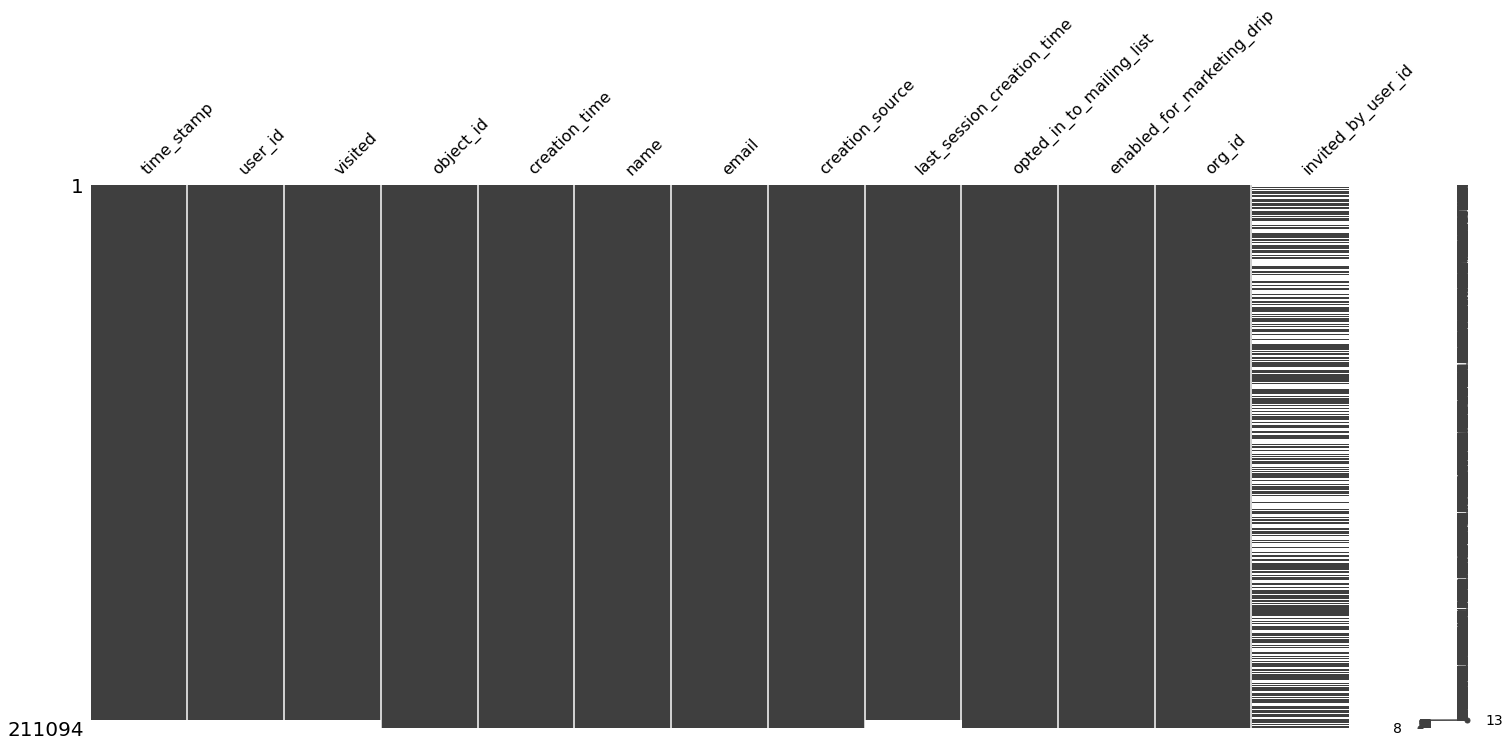

In [620]:
# check missing data
msno.matrix(df);

In [621]:
null_data = df[df.isnull().any(axis=1)]

In [622]:
# loop over the df finding users who have an active date, look 7 days out from that and see if the user's next two dates of
# activity are within the 'week'
active = 0
active_users = []

for i in range(len(df)-2):
    user = df['user_id'][i] # user ID
    if user != active and user == df['user_id'][i+2]:
        start_date = pd.Timestamp(df['time_stamp'][i])
        end_date = start_date + pd.Timedelta('7D') # create the range of a week
        if start_date < pd.Timestamp(df['time_stamp'][i+1]) < end_date \
        and start_date < pd.Timestamp(df['time_stamp'][i+2]) < end_date:
            active_users.append(user)
            active = user
        

In [623]:
# loop over lines and if a user has id in the active_users, assign 1 and if not a 0 for active_list
active_list = []

for i in df.user_id:
    if i in active_users:
        active_list.append(1) 
    else:
        active_list.append(0)

In [624]:
# create active column
df['active'] = active_list

Clean up data

In [625]:
# drop user id as its the same os object_id, and rename object id
df.drop(columns=['user_id'], inplace=True)
df.rename(index=str, columns={'object_id':'user_id'}, inplace=True)

In [626]:
# change not invited from NaN to 0
df.invited_by_user_id.fillna(0, inplace=True)

In [627]:
# for users that didn't log in after creating an account, last session time is NaT, replace with 0 since it represents 
# a timedelta in seconds
df.last_session_creation_time.fillna(0, inplace=True)

In [628]:
# convert time_stamp to M/D/Y columns for random forest
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [629]:
df['time_stamp_year'] = df['time_stamp'].dt.year
df['time_stamp_month'] = df['time_stamp'].dt.month
df['time_stamp_day'] = df['time_stamp'].dt.day

In [630]:
# fill na with 0, from people who didn't log in and had no timestamp
df.time_stamp_day.fillna(0, inplace=True)
df.time_stamp_month.fillna(0, inplace=True)
df.time_stamp_year.fillna(0, inplace=True)

In [631]:
# convert creation_time to timestamp and M/D/Y
df['creation_time'] = pd.to_datetime(df['creation_time'], format='%Y-%m-%d %H:%M:%S')
df['creation_time_year'] = df['creation_time'].dt.year
df['creation_time_month'] = df['creation_time'].dt.month
df['creation_time_day'] = df['creation_time'].dt.day

In [632]:
# drop visited as it is all 1's
df.drop(columns=['visited'], inplace=True)

In [633]:
#dummy encode columns that have strings
df = pd.get_dummies(df, columns=['creation_source'])

In [634]:
y = df.active
X = df.drop(columns=['time_stamp', 'creation_time', 'name', 'email', 'active'])

In [635]:
classifier = RandomForestClassifier()
classifier.fit(X,y)

C:\Users\jason\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [636]:
pd.Series(abs(classifier.feature_importances_), index=X.columns).sort_values(ascending=False)

last_session_creation_time            0.434487
time_stamp_month                      0.106813
creation_time_year                    0.099484
time_stamp_year                       0.093811
creation_time_month                   0.063503
time_stamp_day                        0.054913
org_id                                0.036171
user_id                               0.033611
creation_time_day                     0.032117
invited_by_user_id                    0.023785
enabled_for_marketing_drip            0.004050
creation_source_GUEST_INVITE          0.003527
opted_in_to_mailing_list              0.003488
creation_source_ORG_INVITE            0.002882
creation_source_SIGNUP_GOOGLE_AUTH    0.002556
creation_source_PERSONAL_PROJECTS     0.002555
creation_source_SIGNUP                0.002248
dtype: float64

The most important features for predicting adoption are the last time the user logged in, the time of year (month and year, most likely representing the time from start of this service), and org_id (the id for the group of users). If several people from a group or organization use the service, it is more likely that others will as well and use it more frequently.

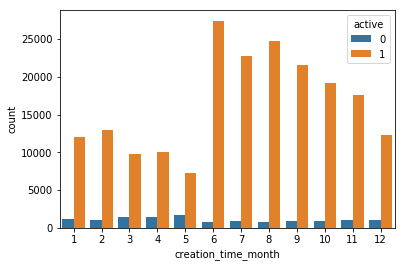

In [637]:
sns.countplot(df.creation_time_month, hue=df.active);

As seen below and above, the start of the service appears to be 5/31, accounting for the rush of users in June and slow but steady decline afterwards.

In [638]:
df.time_stamp.sort_values().head()

178140   2012-05-31 08:20:06
59486    2012-05-31 15:47:36
175638   2012-05-31 17:19:37
26821    2012-05-31 21:58:33
109716   2012-06-01 00:17:30
Name: time_stamp, dtype: datetime64[ns]

In [639]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,time_stamp_year,time_stamp_month,time_stamp_day,creation_time_year,creation_time_month,creation_time_day,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
user_id,1,-0.00181714,-0.0406549,-0.0289652,-0.0329559,0.0771593,-0.00580778,-0.00120267,0.00241132,-2.69857e-05,0.0151901,-0.0113931,-0.0348032,0.0292434,-0.00317448,-0.0140096,-0.0371862,0.02089
last_session_creation_time,-0.00181714,1,0.00434128,0.00383549,0.0258255,0.00912788,0.503943,0.998867,0.198913,0.21472,-0.112338,0.0278054,-0.0114606,0.0129415,-0.000540899,-0.13591,0.0383067,0.0555531
opted_in_to_mailing_list,-0.0406549,0.00434128,1,0.472457,-0.0410979,0.0312203,0.00456383,0.00458888,-0.00663908,0.00142202,0.0325376,-0.0331872,0.0097818,0.0149377,0.0201431,-0.00232,0.012288,-0.0536261
enabled_for_marketing_drip,-0.0289652,0.00383549,0.472457,1,-0.0275997,0.0510538,0.00160608,0.00422584,-0.002083,-0.000194763,-0.0278525,0.0252726,-0.0114298,-0.032166,0.082172,-0.00790102,-0.0269677,-0.0345745
org_id,-0.0329559,0.0258255,-0.0410979,-0.0275997,1,-0.0576791,0.044201,0.0244361,0.00821079,0.0072125,-0.043608,0.0298346,0.0308848,-0.00526106,-0.00623014,-0.0043621,0.092327,-0.0784875
invited_by_user_id,0.0771593,0.00912788,0.0312203,0.0510538,-0.0576791,1,0.00735495,0.00965542,-0.0034115,0.00131687,0.0221324,-0.041771,-0.0277969,0.331023,0.518933,-0.287287,-0.407922,-0.384874
active,-0.00580778,0.503943,0.00456383,0.00160608,0.044201,0.00735495,1,0.479258,0.0924268,0.0984681,-0.265068,0.0742298,-0.0215615,0.0250553,-0.0119116,-0.0625416,0.00410251,0.032959
time_stamp_year,-0.00120267,0.998867,0.00458888,0.00422584,0.0244361,0.00965542,0.479258,1,0.20027,0.214825,-0.111656,0.0273989,-0.0099647,0.0128008,0.000440871,-0.1361,0.0385219,0.0543826
time_stamp_month,0.00241132,0.198913,-0.00663908,-0.002083,0.00821079,-0.0034115,0.0924268,0.20027,1,0.0589429,-0.130625,0.0360849,-0.00578103,0.00328456,-0.0017772,-0.0273473,0.00807893,0.0121616
time_stamp_day,-2.69857e-05,0.21472,0.00142202,-0.000194763,0.0072125,0.00131687,0.0984681,0.214825,0.0589429,1,-0.0188539,0.00433095,0.0335009,0.0045037,-0.000979828,-0.0320157,0.00819113,0.0133979
